In [1]:
import ujson as json
from collections import defaultdict
import copy
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
file_list = [249, 866, 434, 672, 184, 938, 212, 140, 546, 347, 633, 556, 205, 340, 533, 513, 130, 5, 777, 650, 20, 414, 543, 419, 813, 561, 52, 310, 698, 314, 61, 961, 198, 714, 974, 746, 753, 881, 377, 564, 270, 835, 371, 471, 692, 560, 905, 411, 38, 721, 297, 559, 803, 649, 955, 409, 380, 976, 815, 500, 480, 660, 438, 454, 718, 306, 996, 154, 620, 772, 498, 155, 787, 332, 770, 767, 196, 981, 115, 722, 609, 289, 231, 959, 124, 17, 222, 653, 214, 181, 940, 426, 685, 244, 807, 496]

In [3]:
with open('./data/docred/rel2id.json', 'r') as fh:
    rel2id = json.load(fh)

id2rel = {}
for rel, idx in rel2id.items():
    id2rel[idx] = rel

with open('./data/docred/valid_scratch.json', 'r') as fh:
    scratch_dataset = json.load(fh)

In [4]:
with open('./data/docred/dev.json', 'r') as fh:
    dev_dataset = json.load(fh)
doc_titles = [data['title'] for data in dev_dataset]
title2id = {}
for fid, title in enumerate(doc_titles):
    title2id[title] = fid

In [5]:
with open('./data/wikidata/final_id2popular.json', 'r') as fh:
    id2popular = json.load(fh)
with open('./data/wikidata/final_wiki_ids.json', 'r') as fh:
    wiki_ids = json.load(fh)

In [7]:
with open('./data/model_results/96_dev_gain_bert_base_all_results.json', 'r') as fh:
    negative_all_results = json.load(fh)

with open('./data/model_results/96_dev_human_negative_gain_bert_base_all_results.json', 'r') as fh:
    negative_human_results = json.load(fh)

In [8]:
dataset = {
    'n_all': negative_all_results, 
    'n_human': negative_human_results,
}

In [9]:
threshold = {
    'n_human': 0.3312,
    'n_all': 0.4392,
}

In [10]:
# FOR GAIN
ori_htrs = set([(data['title'], label['h'], label['t'], rel2id[label['r']])  for data in scratch_dataset for label in data['labels']])
positive_dataset = {}
for dataset_name, single_dataset in dataset.items():
    positive_dataset[dataset_name] = [res for res in single_dataset if (res['title'], res['h_idx'], res['t_idx'], res['r_idx']) in ori_htrs]

binary_dataset = {}
for dataset_name, single_dataset in positive_dataset.items():
    if dataset_name in threshold:
        binary_dataset[dataset_name] = [{'title': res['title'], 'h_idx': res['h_idx'], 't_idx': res['t_idx'], 'r_idx': res['r_idx'], 'ori_score': res['score'], 'score': int(res['score'] > threshold[dataset_name])} for res in single_dataset]

predict_dataset = {}
for dataset_name, single_dataset in dataset.items():
    predict_dataset[dataset_name] = [{'title': res['title'], 'h_idx': res['h_idx'], 't_idx': res['t_idx'], 'r_idx': res['r_idx'], 'score': 1} for res in single_dataset if res['score'] > threshold[dataset_name]]

### Relation

In [13]:
with open('./data/wikidata/Popular Relations.txt' ,'r') as fh:
    lines = fh.readlines()
popular_relations  = [line.strip().split('\t')[0].split(' ')[-1][1:-1] for line in lines]
popular_relations = set(popular_relations) & set(list(rel2id))
unpopular_relations = [rel for rel in rel2id if rel not in popular_relations and rel != 'Na']

In [11]:
ins_with_rel = defaultdict(list)
for data in scratch_dataset:
    for label in data['labels']:
        ins_with_rel[label['r']].append((data['title'], label['h'], label['t'], rel2id[label['r']]))

In [14]:
pop_rel_instances = []
unpop_rel_instances = []
for rel in popular_relations:
    pop_rel_instances += ins_with_rel[rel]
for rel in unpopular_relations:
    unpop_rel_instances += ins_with_rel[rel]

pop_rel_instances = set(pop_rel_instances)
unpop_rel_instances = set(unpop_rel_instances)

In [15]:
pop_rel_scores = defaultdict(list)
unpop_rel_scores = defaultdict(list)

for dataset_name, single_dataset in binary_dataset.items():
    for res in single_dataset:
        if (res['title'], res['h_idx'], res['t_idx'], res['r_idx']) in pop_rel_instances:
            pop_rel_scores[dataset_name].append(res['score'])
        elif (res['title'], res['h_idx'], res['t_idx'], res['r_idx']) in unpop_rel_instances:
            unpop_rel_scores[dataset_name].append(res['score'])

[0.36177884615384615, 0.45479265805574437, 0.5079365079365079]


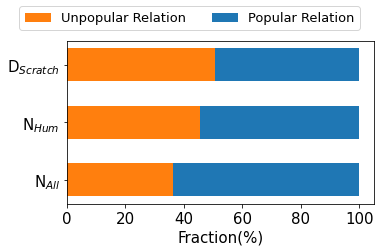

In [30]:
plt.figure(figsize=(5.5, 3))

first = [
    np.sum(unpop_rel_scores['n_all']) / (np.sum(unpop_rel_scores['n_all']) + np.sum(pop_rel_scores['n_all'])),
    np.sum(unpop_rel_scores['n_human']) / (np.sum(unpop_rel_scores['n_human']) + np.sum(pop_rel_scores['n_human'])),
    len(unpop_rel_instances) / (len(unpop_rel_instances) + len(pop_rel_instances))
]

print (first)

second = [1 - t for t in first]


first = [t * 100 for t in first]
second = [t*100 for t in second]

color1 = sns.color_palette()[1]
color2 = sns.color_palette()[0]

plt.barh([1.3,2, 2.7], first, height=0.4, label='Unpopular Relation', color=color1)
plt.barh([1.3,2, 2.7], second, left=first, height=0.4, color=color2, label='Popular Relation')

plt.yticks([1.3,2, 2.7], ['N$_{All}$','N$_{Hum}$', "D$_{Scratch}$"], fontsize=15)

plt.xlabel('Fraction(%)', fontsize=15)
t = plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1.25), ncol=3, fontsize=13)
plt.xticks(fontsize=15)
plt.savefig('./figs/model_relation_bias_cause.pdf', bbox_inches='tight')


### Entity

In [24]:
with open('./data/wikidata/final_id2popular.json', 'r') as fh:
    id2popular = json.load(fh)
with open('./data/wikidata/final_wiki_ids.json', 'r') as fh:
    wiki_ids = json.load(fh)


In [25]:
for dataset_name, single_dataset in binary_dataset.items():
    for res in single_dataset:
        doc_wiki_ids = wiki_ids[title2id[res['title']]]

        h_wiki_ids = doc_wiki_ids[int(res['h_idx'])]
        t_wiki_ids = doc_wiki_ids[int(res['t_idx'])]

        h_popularity = [id2popular[qid] for qid in h_wiki_ids if qid in id2popular]
        t_popularity = [id2popular[qid] for qid in t_wiki_ids if qid in id2popular]

        h_popularity = -1 if len(h_popularity) == 0 else max(h_popularity)
        t_popularity = -1 if len(t_popularity) == 0 else max(t_popularity)

        res['max'] = max(h_popularity, t_popularity)
        res['min'] = min(h_popularity, t_popularity)

n_all [36.13184931506849, 87.38698630136986, 175.83390410958904, 412.7945205479452, 655.2756849315068] [0.1815068493150685, 0.24315068493150685, 0.2979452054794521, 0.3099315068493151, 0.3784246575342466]
n_human [36.13184931506849, 87.38698630136986, 175.83390410958904, 412.7945205479452, 655.2756849315068] [0.4452054794520548, 0.4726027397260274, 0.5291095890410958, 0.4965753424657534, 0.5393835616438356]


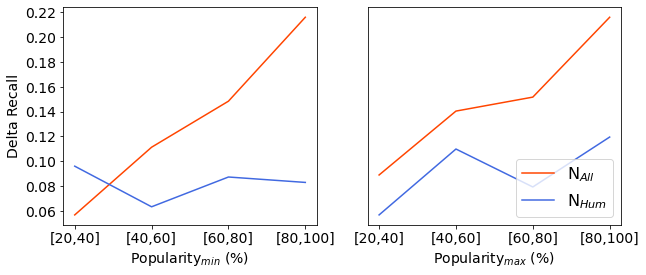

In [29]:
bin_number = 5
model_names = ['n_all', 'n_human'] # 'ssan',
name_mp = {
    'n_all': ['N$_{All}$', 'N$_{All}$'],
    'n_human': ['N$_{Hum}$', 'N$_{Hum}$'],
}

fmts = {
    'n_all': ['r', 'b'],
    'n_human': ['r', 'b']
}

colors = {
    'n_all': ['orangered', 'orangered'],
    'n_human': ['royalblue', 'royalblue']

}


['r--', 'b--', 'r', 'b']
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(121)

# for dataset_name, single_dataset in positive_dataset.items():
for dataset_name in model_names:
    # single_dataset = positive_dataset[dataset_name]
    single_dataset = binary_dataset[dataset_name]
    linked_dataset = [res for res in single_dataset if res['min'] != -1]
    linked_dataset.sort(key=lambda x: x['max'])
    linked_dataset.sort(key=lambda x: x['min'])

    ent_pop = [res['min'] for res in linked_dataset]
    scores = [res['score'] for res in linked_dataset]
    interval = len(scores) // bin_number
    scores = [np.mean(scores[bin_num*interval: (bin_num + 1)*interval]) for bin_num in range(bin_number)]
    ent_pop = [np.mean(ent_pop[bin_num*interval: (bin_num + 1)*interval]) for bin_num in range(bin_number)]

    # x = [20, 40, 60, 80, 100]
    x = ["[20,40]", "[40,60]", "[60,80]", "[80,100]"]

    ax.plot(x, [t - scores[0] for t in scores[1:]], fmts[dataset_name][0], label=name_mp[dataset_name][0], color=colors[dataset_name][0])


    ax.set_xticks(x)
plt.xlabel('Popularity$_{min}$ (%)', fontsize=14)
    # print(dataset_name, ent_pop, scores)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Delta Recall', fontsize=14)
# name_mp = {
#     'ori': 'ALL-Dominant',
#     'wo_dsn': 'HUM-Dominant',
# }
# for dataset_name in model_names:
ax=fig.add_subplot(122)

# for dataset_name, single_dataset in positive_dataset.items():
for dataset_name in model_names:
    single_dataset = binary_dataset[dataset_name]
    linked_dataset = [res for res in single_dataset if res['max'] != -1]
    linked_dataset.sort(key=lambda x: x['min'])
    linked_dataset.sort(key=lambda x: x['max'])

    ent_pop = [res['max'] for res in linked_dataset]
    scores = [res['score'] for res in linked_dataset]
    interval = len(scores) // bin_number
    scores = [np.mean(scores[bin_num*interval: (bin_num + 1)*interval]) for bin_num in range(bin_number)]
    ent_pop = [np.mean(ent_pop[bin_num*interval: (bin_num + 1)*interval]) for bin_num in range(bin_number)]

    # x = [20, 40, 60, 80, 100]
    x = ["[20,40]", "[40,60]", "[60,80]", "[80,100]"]
    plt.plot(x, [t - scores[0] for t in scores[1:]], fmts[dataset_name][1], label=name_mp[dataset_name][1],  color=colors[dataset_name][1])

    print(dataset_name, ent_pop, scores)
    ax.set_yticks([])
plt.xlabel('Popularity$_{max}$ (%)', fontsize=14)

plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(loc='upper left', bbox_to_anchor=(1., 0.2), ncol=1, fontsize=11)
# plt.legend(loc='upper left', fontsize=11)
plt.legend(loc='lower right', fontsize=16)

plt.savefig('./figs/model_entity_bias_cause.pdf', bbox_inches='tight')
# bbox_to_anchor=(1.65, 0.2), ncol=1, fontsize=12)
